# 0.0 Imports

In [96]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import inflection
import re
import umap as umap

from matplotlib import pyplot as plt 
from plotly import express as px
from IPython.display import HTML
# from ydata_profiling import ProfileReportperformance
import sweetviz as sv

from sklearn import cluster as c
from sklearn import metrics 

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## 0.2 Load Data

In [98]:
# load data
df_raw = pd.read_excel('../data/raw/Online Retail.xlsx')
# df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode-escape')
# df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)

# 1.0 Data Description

In [99]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [101]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']
snakecase = lambda x: inflection.underscore( x ) # function to snakecase
cols_news = list( map( snakecase, cols_old ))
df1.columns = cols_news

## 1.3 Check NA

## 1.4 Replace NA

In [105]:
# remove na
df1 = df1.dropna(subset=['description', 'customer_id'])
df_missing = df1[df1['customer_id'].isna()]
print(f'Missing: {df_missing.shape[0]}')
print(f'Not Missing: {df1.shape[0]}')

Missing: 0
Not Missing: 406829


In [106]:
# replace Na
# create reference
backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
backup['customer_id'] = np.arange(19000, 19000+len(backup), 1)

# merge original data frame
df1 = pd.merge(df1, backup, on='invoice_no', how='left')

#coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

## 1.5 Change dtypes

In [108]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

# customer id
df1['customer_id'] = df1['customer_id'].astype( int )

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,17850


# 2.0 Data Filtering

In [115]:
df2 = df1.copy()

In [116]:
# === Numerical attributes ====
df2_purchases = df2.loc[df2['unit_price'] >= 0.04, :]

# === Categorical attributes ====
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL','PADS', 'B', 'CRUK'] )]

# description
df2 = df2.drop( columns='description', axis=1 )

# map 
df2 = df2[~df2['country'].isin( ['European Community', 'Unspecified' ] ) ]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# 3.0 Feature Engineering

In [117]:
df3 = df2_purchases.copy()

## 3.1 Feature Creation

In [118]:
# DF reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 
                    'quantity', 'invoice_date', 'unit_price', 
                    'country'], axis=1 ).drop_duplicates( ignore_index=True )

### Gross Revenue

In [119]:
# Gross revenue
df2_purchases['gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']

# Monetary
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

/tmp/ipykernel_83702/1522764053.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases['gross_revenue'] = df2_purchases['quantity'] * df2_purchases['unit_price']


### Recency - Days since the last purchase

In [120]:
# Recency - Last day purchase
# **inverter função**
df_recency = df2_purchases[['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df2_purchases['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
# df_recency['recency_days'] = df_recency['recency_days'].apply( lambda x: 1 / x if x != 0 else 0)
df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )

### Quantity of purchases

In [121]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                             .groupby( 'customer_id' )
                                                             .count()
                                                             .reset_index()
                                                             .rename( columns={'invoice_no': 'qtde_invoices'}) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
qtde_invoices    0
dtype: int64

### Total of items purchased

In [122]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum()
                                                           .reset_index()
                                                           .rename( columns={'quantity': 'qtde_items'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
qtde_invoices    0
qtde_items       0
dtype: int64

### Totoal of unique products purchased

In [123]:
# Numero de produtos
df_freq = (df2_purchases.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qtde_products'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
qtde_invoices    0
qtde_items       0
qtde_products    0
dtype: int64

### Avg Ticket

In [124]:
# Avg Ticket
df_avg_ticket = df2_purchases.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
qtde_invoices    0
qtde_items       0
qtde_products    0
avg_ticket       0
dtype: int64

### Avg recency days

In [125]:
# Average recency days
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=False )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else 0, axis=1 )
# df_aux['avg_recency_days'] = df_aux['avg_recency_days'].apply( lambda x: 1/x if x !=0 else 0)

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id         0
gross_revenue       0
recency_days        0
qtde_invoices       0
qtde_items          0
qtde_products       0
avg_ticket          0
avg_recency_days    0
dtype: int64

### Frequency of purchases
- frequency = event / time 

In [126]:
df_aux = ( df2_purchases[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )

df_ref.isna().sum()

customer_id         0
gross_revenue       0
recency_days        0
qtde_invoices       0
qtde_items          0
qtde_products       0
avg_ticket          0
avg_recency_days    0
frequency           0
dtype: int64

### Number of returns

In [127]:
# Number of Returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0

df_ref.isna().sum()

customer_id         0
gross_revenue       0
recency_days        0
qtde_invoices       0
qtde_items          0
qtde_products       0
avg_ticket          0
avg_recency_days    0
frequency           0
qtde_returns        0
dtype: int64

### Basket Size

In [128]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                  n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id         0
gross_revenue       0
recency_days        0
qtde_invoices       0
qtde_items          0
qtde_products       0
avg_ticket          0
avg_recency_days    0
frequency           0
qtde_returns        0
avg_basket_size     0
dtype: int64

### Unique Basket Size

In [129]:
df_aux = ( df2_purchases.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_items                0
qtde_products             0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

# 4.0 EDA

In [131]:
df4 = df_ref.copy()
df4 = df4.dropna()

## 4.3 Estudo de espaços

In [132]:
df43 = df4.drop(columns=['customer_id'], axis=1).copy()

In [135]:
X = df43.copy()

### 4.3.4 Tree-based Embedding

In [142]:
from sklearn import ensemble as en

In [143]:
X = df43.drop(columns=['gross_revenue'], axis=1).copy()
y = df43['gross_revenue'].copy()

# model definiton
forest = en.RandomForestRegressor( n_estimators=100, 
                                  random_state=42,
                                   criterion='friedman_mse' )

# model training
forest.fit( X, y )

# predict
df_leaf = pd.DataFrame(forest.apply( X ))

/home/natan/miniconda3/envs/clusterenv/lib/python3.12/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

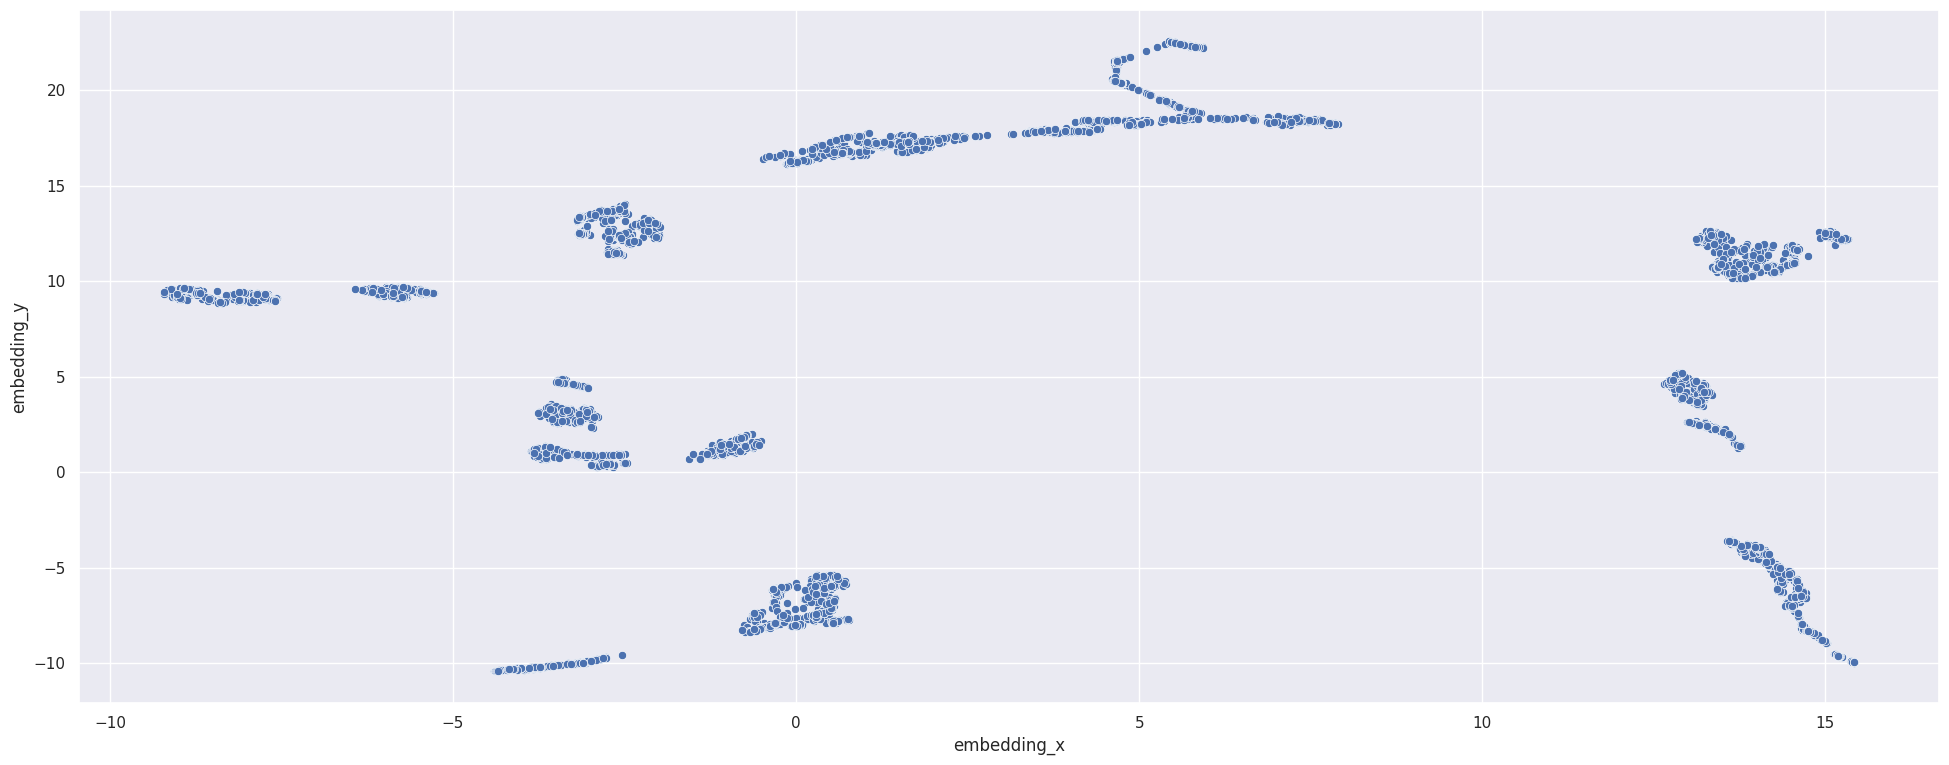

In [144]:
reducer = umap.UMAP( n_neighbors=80, random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# 5.0 Data Preparation

In [145]:
df5 = df4.copy()

# 6.0 Feature Selection

In [146]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tunning

# 8.0 Model Training

## 8.1 K-Means

In [169]:
# Model definition
k = 10
kmeans = c.KMeans( init='random', n_clusters=k, n_init=10, random_state=42, max_iter=300 )

# model training
kmeans.fit( X )

# clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [161]:
# WSS (Within-cluster sum of square)
print(kmeans.inertia_)

# SS (Silhouette Score)
print(metrics.silhouette_score( X, labels, metric='euclidean'))

10983.681640625


0.6995869


# 9.0 Cluster Analyslis

In [171]:
df9 = df6.copy()
df9['cluster'] = labels
X['cluster'] = labels

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_items,qtde_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size,cluster
0,17850,5391.21,371,34,1733,297,18.152222,-3.000000,17.000000,40.0,50.970588,0.617647,5
1,13047,3232.59,56,9,1390,171,18.904035,-22.333333,0.028302,35.0,154.444444,11.666667,5
2,12583,6705.38,2,15,5028,232,28.902500,-22.352941,0.040431,50.0,335.200000,7.600000,7
3,13748,948.25,95,5,439,28,33.866071,-70.000000,0.017921,0.0,87.800000,4.800000,8
4,15100,876.00,333,3,80,3,292.000000,-7.666667,0.073171,22.0,26.666667,0.333333,9


## 9.2 Cluster Profile

In [84]:
# df9['avg_recency_days'] = df9['avg_recency_days'].apply( lambda x: 1/x if x !=0 else 0)
# df9['recency_days'] = df9['recency_days'].apply( lambda x: 1/x if x !=0 else 0)

In [175]:
# Number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg invoice_no
df_invoice_no = df9[['qtde_invoices', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_invoice_no, how='inner', on='cluster' )

# Avg Qnt_items
df_items_no = df9[['qtde_items', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_items_no, how='inner', on='cluster' )

# Avg frequency
df_frequency_no = df9[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency_no, how='inner', on='cluster' )

# Avg returns
df_returns_no = df9[['qtde_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_returns_no, how='inner', on='cluster' )

In [176]:
df_cluster.sort_values('gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtde_invoices,qtde_items,frequency,qtde_returns
7,7,479,11.059801,11225.436701,25.872651,15.181628,6814.043841,0.098949,494.830898
5,5,374,8.635419,2570.682807,41.339572,6.631016,1586.058824,0.107853,22.366310
3,3,445,10.274763,1756.879348,44.058427,5.447191,996.276404,0.075215,20.997753
8,8,602,13.899792,1164.889618,65.014950,3.576412,619.805648,0.172444,10.189369
4,4,404,9.328100,684.676015,94.254950,2.027228,422.113861,0.368370,6.190594
2,2,389,8.981759,555.303316,76.089974,2.838046,262.622108,0.026766,4.066838
1,1,365,8.427615,401.047123,136.076712,1.126027,256.989041,0.995809,3.665753
0,0,381,8.797045,322.561709,129.078740,1.737533,133.217848,0.537492,1.451444
6,6,242,5.587624,290.750744,140.586777,1.099174,163.413223,1.014587,1.838843
9,9,650,15.008081,169.746046,168.864615,1.256923,59.572308,0.874062,1.756923


# 10.0 Deploy

# 11.0 Insert into SQLITE

In [177]:
import sqlite3
from sqlalchemy import create_engine

In [178]:
# create table
query_create_table_insiders = """
    CREATE TABLE insiders (
    customer_id       INTEGER,  
    gross_revenue     REAL,
    recency_days      REAL,
    qtde_invoices     INTEGER,  
    qtde_items        INTEGER,  
    qtde_products     INTEGER,  
    avg_ticket        REAL,
    avg_recency_days  REAL,
    frequency         REAL,
    qtde_returns      REAL,
    avg_basket_size   REAL,
    avg_unique_basket_size  REAL,
    cluster            INTEGER 
    )
"""

conn = sqlite3.connect( 'insiders_db.sqlite' )
conn.execute( query_create_table_insiders )
conn.commit()
conn.close()

# inseert data
conn = create_engine( 'sqlite:///insiders_db.sqlite' )
df9.to_sql( 'insiders', con=conn, if_exists='append', index=False)

4331

In [179]:
query = """
SELECT * FROM insiders"""

df = pd.read_sql_query( query, conn)